データ準備

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
import warnings

# すべての警告メッセージを無視する
warnings.filterwarnings("ignore")

# ここからは警告メッセージが表示されなくなります

In [3]:
# CSVファイルを読み込んで、Pandasデータフレーム化する
df = pd.read_csv('online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


-------------------------------------------------------

<Axes: xlabel='Quantity'>

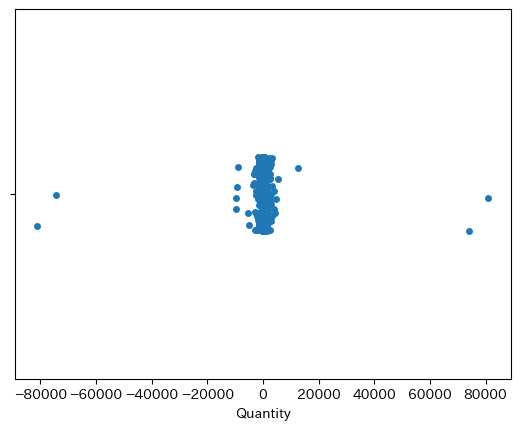

In [4]:
#Quantityをプロットグラフで可視化
import seaborn as sns
sns.stripplot(x='Quantity', data=df)

In [5]:
#マイナス値のあるQuantityカラムまたはUnitPriceカラム
df_minus = df.query('Quantity <= 0 or UnitPrice <= 0')
df_minus.shape

(11805, 8)

In [6]:
#マイナス値を除外したデータ
df = df.drop(df_minus.index, axis=0)
df.shape

(530104, 8)

<Axes: xlabel='UnitPrice'>

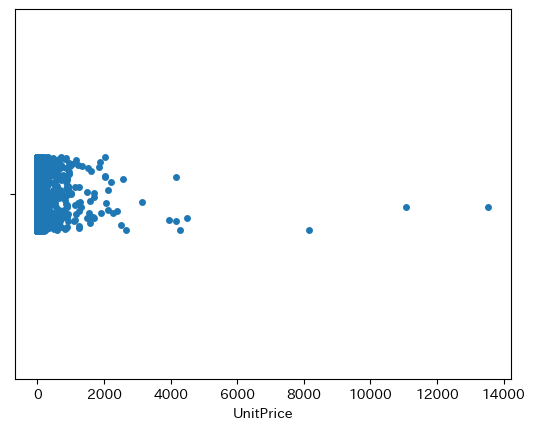

In [7]:
#UnitPriceをプロットグラフで可視化
import seaborn as sns
sns.stripplot(x='UnitPrice', data=df)

In [8]:
#Quantityの四分位範囲から外れ値を除去する。
10 + 1.5 * 10

25.0

In [9]:
df = df.drop(df.query('Quantity > 25').index)
df.shape

(502865, 8)

In [10]:
# レコードごとの購入金額（UnitPrice * Quantity)をX軸に描写
df['TotalValue'] = df['UnitPrice'] * df['Quantity']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


-------------------------------------------------------

# データ集計・分析

次の内容を、Python（主にPandas）と、SQLを使ってそれぞれ集計してください。（両方が難しい場合は、どちらか一方でも構いません。）

データ集計・分析では、df_sampleではなくdfを使うようにしてください

# SQL実行
df_output = duckdb.query(
  f"""
  SELECT -- ここに必要な処理を書く
  FROM df -- テーブルには、Pandasのデータフレームを利用
  """
).to_df()

In [11]:
#pip install duckdb-engine
#SQL実行のためのライブラリduckdbをインポート
import duckdb

-------------------------------------------------------

In [12]:
# 1. 2011年1～6月の期間における、商品（StockCode, Description）ごとの合計売上金額を算出し、金額が高い順に順位をつけてください

In [13]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
TotalValue     float64
dtype: object

In [14]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [15]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
TotalValue            float64
dtype: object

In [16]:
_df_sales_product = df[(df['InvoiceDate'] >= '2011-1') & (df['InvoiceDate'] < '2011-07')]

In [17]:
_df_sales_product = _df_sales_product.groupby(['StockCode', 'Description'])['TotalValue'].sum().reset_index()
_df_sales_product = _df_sales_product.sort_values(by='TotalValue', ascending=False)
df_sales_product = _df_sales_product
df_sales_product.head()

,StockCode,Description,TotalValue
3454,DOT,DOTCOM POSTAGE,65425.44
1266,22423,REGENCY CAKESTAND 3 TIER,55421.83
3457,POST,POSTAGE,35947.18
3455,M,Manual,29819.22
2334,47566,PARTY BUNTING,24665.24


In [18]:
df_sales_product_sql = duckdb.query(
  f"""
  SELECT StockCode, Description, SUM(TotalValue) AS TotalSales
  FROM df
  WHERE EXTRACT(year FROM InvoiceDate) = 2011
  AND EXTRACT(month FROM InvoiceDate) BETWEEN 1 AND 6
  GROUP BY StockCode, Description
  ORDER BY TotalSales DESC
  """
).to_df()

df_sales_product_sql.head()

,StockCode,Description,TotalSales
0,DOT,DOTCOM POSTAGE,65425.44
1,22423,REGENCY CAKESTAND 3 TIER,55421.83
2,POST,POSTAGE,35947.18
3,M,Manual,29819.22
4,47566,PARTY BUNTING,24665.24


-------------------------------------------------------

In [19]:
# 2. #1で出した売り上げ金額が高い順に並べて、金額の累計が総売上金額の70%以下をAランク、70~90%以下をBランク、それ以降をCランクとしてラベルをつけてください
# 売り上げの70%が上位何%の商品数で占められているかを計算してください

# 参考：https://gmo-research.jp/research-column/abc-analysis

In [20]:
#累計総売り上げ金額をデータフレームに追加する。 TotalValueを.cumcum()する。
df_sales_product['CumulativeValue'] = df_sales_product['TotalValue'].cumsum()
#総売り上げを算出する。　すべてのTotalValueを合計する。
total_sales_sum = df_sales_product['TotalValue'].sum()
#Rankデータフレームを追加して、累計総売り上げ/総売り上げから70％、70～90％、それ以降に分けてABCのラベルをつける。
df_sales_product['Rank'] = pd.cut(df_sales_product['CumulativeValue'] / total_sales_sum, bins=[0, 0.7, 0.9, 1.0], labels=['A', 'B', 'C'])
#Cumulativesales列に累計総売り上げ金額、RankにABCのランクが追加されたか確認する。
df_sales_product.head()

,StockCode,Description,TotalValue,CumulativeValue,Rank
3454,DOT,DOTCOM POSTAGE,65425.44,65425.44,A
1266,22423,REGENCY CAKESTAND 3 TIER,55421.83,120847.27,A
3457,POST,POSTAGE,35947.18,156794.45,A
3455,M,Manual,29819.22,186613.67,A
2334,47566,PARTY BUNTING,24665.24,211278.91,A


In [21]:
#総商品数＝行を数える
len(df_sales_product)

3464

In [22]:
#RankAが占める商品数
products_a_count = len(df_sales_product.query("Rank == 'A'"))
#総商品数のうち、RankAが占める商品数の割合
rank_a = (products_a_count / len(df_sales_product)) * 100
print(f"売り上げの70%が上位{round(rank_a, 1)}%の商品数で占められている。")

売り上げの70%が上位14.9%の商品数で占められている。


ABCランク毎の商品数の割合


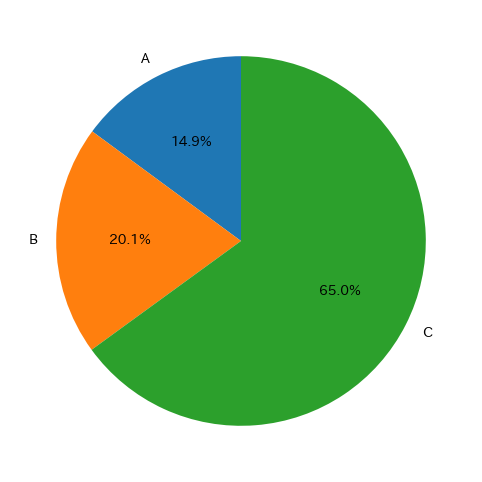

In [23]:
print('ABCランク毎の商品数の割合')
product_counts = df_sales_product.groupby('Rank').size()
plt.figure(figsize=(8, 6))
plt.pie(product_counts, labels=product_counts.index, autopct='%1.1f%%', startangle=90)
plt.show()

つまり何をしたのか

降順にしたデータのTotalValue累積合計を追加して、データフレームCumulativeValueに入れる。

商品の累積合計70％以下をA、70～90％をB、それ以降をCとしてラベルを付ける。

総商品数＝すべての行の数、Aランクの商品数＝Aのラベルがついた行の数

Aランクの商品数/総商品数を求めることで、売り上げの70％（Aランク）が総商品数のうち何％を占めているかを求められる。

In [24]:
df_sale_rank = duckdb.query(
    """
    SELECT *,
       CASE
           WHEN CumulativeTotalSales <= 0.7 * MAX(CumulativeTotalSales) OVER () THEN 'A'
           WHEN CumulativeTotalSales <= 0.9 * MAX(CumulativeTotalSales) OVER () THEN 'B'
           ELSE 'C'
       END AS Label
    FROM (
        SELECT *,
               SUM(TotalSales) OVER (ORDER BY 1 ROWS BETWEEN UNBOUNDED PRECEDING AND CURRENT ROW) AS CumulativeTotalSales
    FROM df_sales_product_sql
    ) AS subquery;
    """
).to_df()

# データフレームの先頭を表示する
df_sale_rank.head()

,StockCode,Description,TotalSales,CumulativeTotalSales,Label
0,DOT,DOTCOM POSTAGE,65425.44,65425.44,A
1,22423,REGENCY CAKESTAND 3 TIER,55421.83,120847.27,A
2,POST,POSTAGE,35947.18,156794.45,A
3,M,Manual,29819.22,186613.67,A
4,47566,PARTY BUNTING,24665.24,211278.91,A


-------------------------------------------------------

In [25]:
# 3. すべての期間において、顧客ごとの購入金額を算出し、金額が高い順に同じ人数になるように、10グループを作成してください

何をするべきか。

必要なデータ：df, CustomerID, TotalValue

CustomerIDに欠損値が多かったのでデータを確認して削除を検討する。

各CustomerIDに対しての合計購入金額を算出してデータフレーム列（TotalParchase)に加える。

ToralParchase列を降順に並べる。

CustomerIDの行数を取得して、10で割った数ごとに１～１０の番号を振る(RankParchase)。

In [26]:
df_isna = df[df.isna().any(axis=1)]
df_na = df.drop(df_isna.index)
df_na.shape

(372154, 9)

In [27]:
_df_customer_totalvalue = df_na[['CustomerID', 'TotalValue']]
_df_customer_totalvalue.head()

,CustomerID,TotalValue
0,17850.0,15.30
1,17850.0,20.34
2,17850.0,22.00
3,17850.0,20.34
4,17850.0,20.34


In [28]:
_df_customer_totalvalue.info()

<class 'pandas.core.frame.DataFrame'>
Index: 372154 entries, 0 to 541908
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   CustomerID  372154 non-null  float64
 1   TotalValue  372154 non-null  float64
dtypes: float64(2)
memory usage: 8.5 MB


データ数が37万に減ったが明確に顧客が絞れたとしてこのまま続ける。

カード会員か何か。

In [29]:
#カスタマーIDをグループ化してTotalValueを合計する。
_df_customer_totalvalue = _df_customer_totalvalue.groupby(['CustomerID'])[['TotalValue']].sum().reset_index()
#顧客ごとの購入金額を算出したデータフレーム
_df_customer_totalvalue = _df_customer_totalvalue.sort_values(by='TotalValue', ascending=False).reset_index()
df_customer_totalvalue = _df_customer_totalvalue
df_customer_totalvalue.head()

,index,CustomerID,TotalValue
0,1843,14911.0,114305.70
1,1264,14096.0,61210.08
2,549,13089.0,43423.03
3,3925,17841.0,39232.31
4,1406,14298.0,27316.95


In [30]:
#顧客数の取得
customer_count = df_customer_totalvalue.shape[0]
customer_count

4238

In [31]:
base_customer_count = customer_count // 10
amari_customer_count = customer_count % 10
#グループごとの人数を格納するリストを初期化
group_counts = [base_customer_count] * 10
#余りを各グループに1人ずつ追加
for i in range(amari_customer_count):
    group_counts[i] += 1

group_counts

[424, 424, 424, 424, 424, 424, 424, 424, 423, 423]

In [32]:
#１０グループに分たデータフレーム
num_groups = 10
df_customer_totalvalue['Group'] = pd.qcut(df_customer_totalvalue.index, num_groups, labels=range(1, num_groups+1))
df_customer_totalvalue

,index,CustomerID,TotalValue,Group
0,1843,14911.0,114305.70,1
1,1264,14096.0,61210.08,1
2,549,13089.0,43423.03,1
3,3925,17841.0,39232.31,1
4,1406,14298.0,27316.95,1
...,...,...,...,...
4233,3481,17212.0,3.95,10
4234,3148,16738.0,3.75,10
4235,1268,14101.0,2.95,10
4236,2943,16446.0,2.90,10


In [33]:
def group(num):
  return df_customer_totalvalue.query('Group == @num')

group(1).head()

,index,CustomerID,TotalValue,Group
0,1843,14911.0,114305.70,1
1,1264,14096.0,61210.08,1
2,549,13089.0,43423.03,1
3,3925,17841.0,39232.31,1
4,1406,14298.0,27316.95,1


In [34]:
'''
カスタマーIDの欠損値を含む行を削除するために、
SQLクエリ内でDELETE文を使用するのではなく、
WHERE句を使用して条件を指定し、欠損値を含む行を除外する方が適切です。
'''
#CustomerIDの欠損値を除去
df_customer_group = duckdb.query(
    """
    SELECT * FROM df
    WHERE CustomerID IS NOT NULL
    """
).to_df()

#各顧客に対しての合計購入金額を算出して新たな列にポイして降順に並べる。
df_customer_group = duckdb.query(
    """
    SELECT CustomerID, SUM(TotalValue) AS TotalPurchase
    FROM df_customer_group
    GROUP BY CustomerID
    ORDER BY TotalPurchase DESC
    """
).to_df()

df_customer_group = duckdb.query(
    """
    SELECT *,
       NTILE(10) OVER (ORDER BY TotalPurchase DESC) AS Group
    FROM df_customer_group;
    """
).to_df()

# データフレームの先頭を表示する
df_customer_group

,CustomerID,TotalPurchase,Group
0,14911.0,114305.70,1
1,14096.0,61210.08,1
2,13089.0,43423.03,1
3,17841.0,39232.31,1
4,14298.0,27316.95,1
...,...,...,...
4233,17212.0,3.95,10
4234,16738.0,3.75,10
4235,14101.0,2.95,10
4236,16446.0,2.90,10


-------------------------------------------------------

In [35]:
# 4. すべての期間において、顧客ごとのRFM分析（R:最終購入日、F:購入回数、M:購入金額）を行ってください

[RFM分析とは？](https://cacco.co.jp/datascience/blog/statistics/259/#:~:text=RFM%E5%88%86%E6%9E%90%E3%82%92%E8%A1%8C%E3%81%86%E3%81%93%E3%81%A8,%E7%9A%84%E3%81%AB%E6%89%93%E3%81%A1%E5%87%BA%E3%81%9B%E3%82%8B%E3%81%AE%E3%81%A7%E3%81%99%E3%80%82)


何をするべきか

必要なデータ：CustemerID, InvoiceDate, TotalValue

作るデータフレーム列：CustemerID, LastParchaseDate, CumulativeParchase, TotalParchase

dfからCustemerIDを取得してグループ化する？

CustemerIDの最終購入日をLastParchaseDate列に入れる。

CustemerID毎のdfでの出現回数をCumulativeParchase列に入れる？

CustemerIDのTotalValue.sumをTotalParchase列に入れる？

In [37]:
# InvoiceNoごとにCustomerIDのリストを取得
"""
df_frequency = df.groupby('InvoiceDate')['CustomerID'].unique().reset_index(name='CustomerID')
df_frequency = df_frequency.groupby('CustomerID').count().reset_index(name='購入回数')
df_frequency
"""

"\ndf_frequency = df.groupby('InvoiceDate')['CustomerID'].unique().reset_index(name='CustomerID')\ndf_frequency = df_frequency.groupby('CustomerID').count().reset_index(name='購入回数')\ndf_frequency\n"

In [38]:
# Recency=最終購入日　を計算
current_date = df['InvoiceDate']
df['最終購入日'] = current_date

# Frequency=購入回数 を計算
df_frequency = df.groupby('CustomerID').size().reset_index(name='購入回数')

# Monetary=購入金額　を計算
df_monetary = df.groupby('CustomerID')['TotalValue'].sum().reset_index(name='購入金額')

# RFMデータフレームを作成
df_rfm = pd.merge(df_frequency, df_monetary, on='CustomerID')
df_rfm['最終購入日'] = df.groupby('CustomerID')['最終購入日'].max().values
df_rfm['最終購入日'] = pd.to_datetime(df_rfm['最終購入日']).dt.strftime('%Y-%m-%d')

df_rfm = df_rfm[['CustomerID', '最終購入日', '購入回数', '購入金額']]

df_rfm

,CustomerID,最終購入日,購入回数,購入金額
0,12347.0,2011-12-07,173,3643.58
1,12348.0,2011-09-25,10,450.20
2,12349.0,2011-11-21,71,1667.55
3,12350.0,2011-02-02,17,334.40
4,12352.0,2011-11-03,85,2506.04
...,...,...,...,...
4233,18280.0,2011-03-07,10,180.60
4234,18281.0,2011-06-12,7,80.82
4235,18282.0,2011-12-02,11,164.13
4236,18283.0,2011-12-06,756,2094.88


これだと同じ日付に購入したCustomerIDの数も数えてしまっている？

In [39]:
_df_r = df_rfm.sort_values(by='最終購入日', ascending=False).reset_index()

num_rows = len(_df_r)
group_size = num_rows // 3

_df_r['点数'] = pd.cut(_df_r.index, bins=[0, group_size, group_size*2, num_rows], labels=[3, 2, 1], include_lowest=True)

_df_r

,index,CustomerID,最終購入日,購入回数,購入金額,点数
0,1509,14446.0,2011-12-09,289,998.90,3
1,1233,14051.0,2011-12-09,185,11962.51,3
2,60,12423.0,2011-12-09,125,1859.31,3
3,3741,17581.0,2011-12-09,406,9004.86,3
4,2154,15344.0,2011-12-09,26,563.94,3
...,...,...,...,...,...,...
4233,4089,18074.0,2010-12-01,10,298.40,1
4234,1364,14237.0,2010-12-01,9,161.00,1
4235,2026,15165.0,2010-12-01,27,487.75,1
4236,3978,17908.0,2010-12-01,57,237.40,1


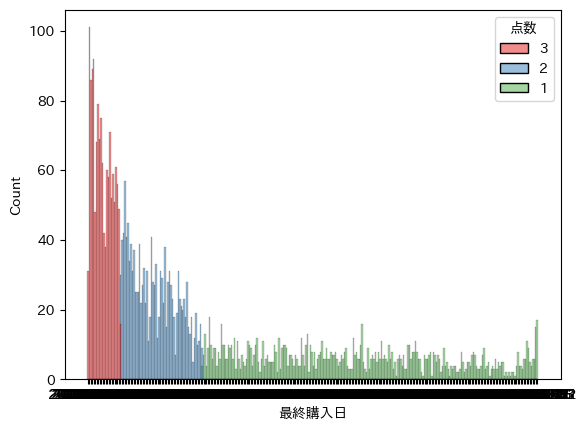

In [ ]:
sns.histplot(data=_df_r, x='最終購入日', bins=10, hue='点数', palette='Set1')
plt.show()

In [ ]:
_df_f = df_rfm.sort_values(by='購入回数', ascending=False).reset_index(drop=True)

num_rows = len(_df_f)
group_size = num_rows // 3

_df_f['点数'] = pd.cut(_df_f.index, bins=[0, group_size, group_size*2, num_rows], labels=[3, 2, 1], include_lowest=True)

_df_f

,CustomerID,最終購入日,購入回数,購入金額,点数
0,17841.0,2011-12-08,7801,39232.31,3
1,14911.0,2011-12-08,5272,114305.70,3
2,14096.0,2011-12-05,5070,61210.08,3
3,12748.0,2011-12-09,4462,26149.89,3
4,14606.0,2011-12-08,2682,11404.41,3
...,...,...,...,...,...
4233,13217.0,2011-08-09,1,52.02,1
4234,13216.0,2011-03-17,1,10.50,1
4235,16765.0,2011-02-18,1,34.00,1
4236,17102.0,2011-03-23,1,25.50,1


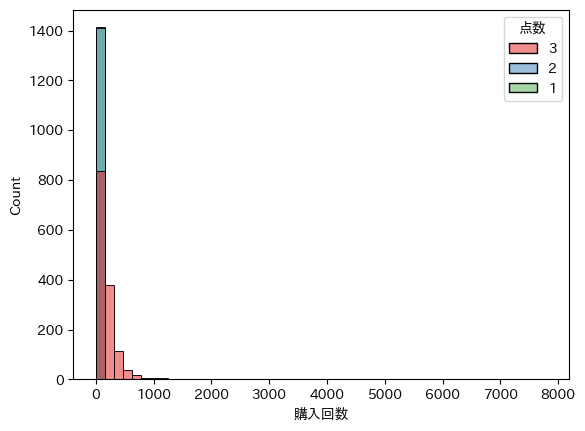

In [ ]:
sns.histplot(data=_df_f, x='購入回数', bins=50, hue='点数', palette='Set1')
plt.show()

In [ ]:
_df_m = df_rfm.sort_values(by='購入金額', ascending=False).reset_index(drop=True)
num_rows = len(_df_m)
group_size = num_rows // 3
_df_m['点数'] = pd.cut(_df_m.index, bins=[0, group_size, group_size*2, num_rows], labels=[3, 2, 1], include_lowest=True)
_df_m

,CustomerID,最終購入日,購入回数,購入金額,点数
0,14911.0,2011-12-08,5272,114305.70,3
1,14096.0,2011-12-05,5070,61210.08,3
2,13089.0,2011-12-07,1652,43423.03,3
3,17841.0,2011-12-08,7801,39232.31,3
4,14298.0,2011-12-01,1046,27316.95,3
...,...,...,...,...,...
4233,17212.0,2011-03-31,1,3.95,1
4234,16738.0,2011-02-15,1,3.75,1
4235,14101.0,2011-02-18,2,2.95,1
4236,16446.0,2011-05-18,2,2.90,1


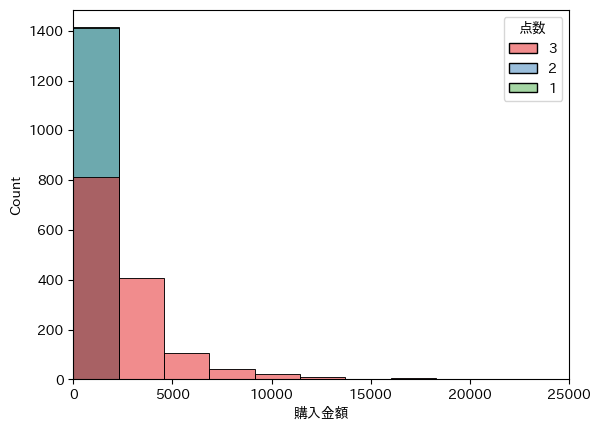

In [ ]:
sns.histplot(data=_df_m, x='購入金額', bins=50, hue='点数', palette='Set1')
plt.xlim(0,25000)
plt.show()

In [ ]:
_df_r = _df_r.rename(columns={'点数': 'R点数'})

_df_rfm = pd.merge(_df_r, _df_f[['CustomerID', '点数']], on='CustomerID', how='left')
_df_rfm = _df_rfm.rename(columns={'点数': 'F点数'})

_df_rfm = pd.merge(_df_rfm, _df_m[['CustomerID', '点数']], on='CustomerID', how='left')
_df_rfm = _df_rfm.rename(columns={'点数': 'M点数'})

_df_rfm['合計点数'] = (_df_rfm['R点数'].astype(int) + _df_rfm['F点数'].astype(int)+ _df_rfm['M点数'].astype(int))

_df_rfm = _df_rfm.sort_values(by='合計点数', ascending=False).reset_index()

_df_rfm['グループ'] = pd.cut(_df_rfm.index, bins=[0, group_size, group_size*2, num_rows], labels=['優良顧客', '普通顧客', '離反顧客'], include_lowest=True)

df_rfm = _df_rfm

df_rfm

,level_0,index,CustomerID,最終購入日,購入回数,購入金額,R点数,F点数,M点数,合計点数,グループ
0,0,1509,14446.0,2011-12-09,289,998.90,3,3,3,9,優良顧客
1,693,899,13576.0,2011-11-29,98,2032.66,3,3,3,9,優良顧客
2,675,1324,14180.0,2011-11-29,240,4748.52,3,3,3,9,優良顧客
3,676,1195,13999.0,2011-11-29,203,3748.41,3,3,3,9,優良顧客
4,677,262,12670.0,2011-11-29,85,2583.97,3,3,3,9,優良顧客
...,...,...,...,...,...,...,...,...,...,...,...
4233,3793,2032,15178.0,2011-03-24,3,40.50,1,1,1,3,離反顧客
4234,3471,352,12790.0,2011-05-31,21,324.92,1,1,1,3,離反顧客
4235,2989,470,12968.0,2011-08-19,5,135.95,1,1,1,3,離反顧客
4236,3796,853,13512.0,2011-03-24,15,251.21,1,1,1,3,離反顧客


In [40]:
_df_r_mode = df_rfm.groupby('グループ')['最終購入日'].apply(lambda x: x.mode())
_df_r_mode = pd.DataFrame(_df_r_mode).reset_index()
_df_r_mode = _df_r_mode.rename(columns={'最終購入日': '最頻最終購入日'})
_df_r_mode = _df_r_mode.drop('level_1', axis=1)
_df_r_mode

KeyError: 'グループ'

In [ ]:
_df_f_mean = df_rfm.groupby('グループ')['購入回数'].mean()
_df_f_mean = pd.DataFrame(_df_f_mean).reset_index()
_df_f_mean = _df_f_mean.rename(columns={'購入回数': '平均購入回数'})
_df_f_mean

,グループ,平均購入回数
0,優良顧客,202.301486
1,普通顧客,46.603399
2,離反顧客,14.506723


In [ ]:
_df_m_mean = df_rfm.groupby('グループ')['購入金額'].mean()
_df_m_mean = pd.DataFrame(_df_m_mean).reset_index()
_df_m_mean = _df_m_mean.rename(columns={'購入金額': '平均購入金額'})
_df_m_mean

,グループ,平均購入金額
0,優良顧客,2899.932669
1,普通顧客,665.396517
2,離反顧客,217.969371


In [ ]:
import math
_df_f_mean['平均購入回数'] = _df_f_mean['平均購入回数'].apply(math.floor)
_df_m_mean['平均購入金額'] = _df_m_mean['平均購入金額'].apply(math.floor)
df_rfm_summary = pd.merge(_df_r_mode, _df_f_mean[['グループ', '平均購入回数']], on='グループ', how='left')
df_rfm_summary = pd.merge(df_rfm_summary, _df_m_mean[['グループ', '平均購入金額']], on='グループ', how='left')
df_rfm_summary

,グループ,最頻最終購入日,平均購入回数,平均購入金額
0,優良顧客,2011-12-08,202,2899
1,普通顧客,2011-12-05,46,665
2,離反顧客,2011-10-17,14,217


優良顧客と普通顧客の平均購入回数と平均購入金額の差が大きい。

In [41]:
#R点数をつける。
_df_customer_group_r = duckdb.query(
    """
    SELECT CustomerID AS 顧客, 最終購入日,
        4 - NTILE(3) OVER (ORDER BY 最終購入日 DESC) AS R点数
    FROM(
    SELECT CustomerID, MAX(CAST(InvoiceDate AS DATE)) AS 最終購入日
    FROM df
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID
    ORDER BY 最終購入日 DESC
    ) AS subquery
    """
).to_df()

_df_customer_group_r

,顧客,最終購入日,R点数
0,12662.0,2011-12-09,3
1,15311.0,2011-12-09,3
2,12423.0,2011-12-09,3
3,14446.0,2011-12-09,3
4,17581.0,2011-12-09,3
...,...,...,...
4233,14237.0,2010-12-01,1
4234,18074.0,2010-12-01,1
4235,16583.0,2010-12-01,1
4236,15350.0,2010-12-01,1


In [42]:
#F点数をつける。
_df_customer_group_f = duckdb.query(
    """
    SELECT InvoiceNo, ARRAY_AGG(DISTINCT CustomerID) AS 顧客
    FROM df
    WHERE CustomerID IS NOT NULL
    GROUP BY InvoiceNo
    """
).to_df()

_df_customer_group_f = duckdb.query(
    """
    SELECT 顧客, COUNT(顧客) AS 購入回数
    FROM _df_customer_group_f
    GROUP BY 顧客
    ORDER BY 購入回数 DESC
    """
).to_df()

_df_customer_group_f = duckdb.query(
    """
    SELECT UNNEST(顧客) AS 顧客, 購入回数,
        4 - NTILE(3) OVER (ORDER BY 購入回数 DESC) AS F点数
    FROM _df_customer_group_f
    """
).to_df()

_df_customer_group_f

,顧客,購入回数,F点数
0,12748.0,203,3
1,14911.0,198,3
2,17841.0,123,3
3,14606.0,93,3
4,15311.0,91,3
...,...,...,...
4233,12707.0,1,1
4234,16872.0,1,1
4235,17614.0,1,1
4236,17205.0,1,1


In [43]:
#M点数をつける。
_df_customer_group_m = duckdb.query(
    """
    SELECT CustomerID AS 顧客, SUM(TotalValue) AS 購入金額
    FROM df
    WHERE CustomerID IS NOT NULL
    GROUP BY CustomerID
    ORDER BY 購入金額 DESC
    """
).to_df()

_df_customer_group_m = duckdb.query(
    """
    SELECT 顧客, 購入金額,
        4 - NTILE(3) OVER (ORDER BY 購入金額 DESC) AS M点数
    FROM _df_customer_group_m
    """
).to_df()

_df_customer_group_m

,顧客,購入金額,M点数
0,14911.0,114305.70,3
1,14096.0,61210.08,3
2,13089.0,43423.03,3
3,17841.0,39232.31,3
4,14298.0,27316.95,3
...,...,...,...
4233,17212.0,3.95,1
4234,16738.0,3.75,1
4235,14101.0,2.95,1
4236,16446.0,2.90,1


In [44]:
_df_customer_group = duckdb.query(
    """
    SELECT r.顧客, r.R点数, f.F点数, m.M点数, r.R点数 + f.F点数 + m.M点数 AS 合計
    FROM _df_customer_group_r AS r
    JOIN _df_customer_group_f AS f ON r.顧客 = f.顧客
    JOIN _df_customer_group_m AS m ON r.顧客 = m.顧客
    """
).to_df()

_df_customer_group = duckdb.query(
    """
    SELECT 顧客, R点数, F点数, M点数, R点数 + F点数 + M点数 AS 合計
    FROM _df_customer_group
    """
)

_df_customer_group

: 

-------------------------------------------------------

In [ ]:
# 5. すべての期間において、国ごとの総売り上げを月の順番で並べてください

In [ ]:
first_date = df['InvoiceDate'].min()
last_date = df['InvoiceDate'].max()
print(first_date)
print(last_date)

2010-12-01 08:26:00
2011-12-09 12:50:00


In [ ]:
_df_uriage_country = df[df['Country'] == 'United Kingdom'].copy()

_df_uriage_country['Date'] = _df_uriage_country['InvoiceDate'].dt.to_period('M')
_df_uriage_country = _df_uriage_country.groupby(['Date', 'Country'])['TotalValue'].sum().reset_index()

# 結果を表示
_df_uriage_country

,Date,Country,TotalValue
0,2010-12,United Kingdom,506786.350
1,2011-01,United Kingdom,347755.350
2,2011-02,United Kingdom,307389.460
3,2011-03,United Kingdom,398700.590
4,2011-04,United Kingdom,328824.361
5,2011-05,United Kingdom,436382.380
6,2011-06,United Kingdom,384299.500
7,2011-07,United Kingdom,400687.741
8,2011-08,United Kingdom,398740.850
9,2011-09,United Kingdom,575483.992


In [ ]:
countries = [
    'United Kingdom', 'Australia', 'Austria', 'Bahrain', 'Belgium', 'Brazil', 'Canada', 'Channel Islands',
    'Cyprus', 'Czech Republic', 'Denmark', 'EIRE', 'European Community', 'Finland',
    'France', 'Germany', 'Greece', 'Hong Kong', 'Iceland', 'Israel', 'Italy', 'Japan',
    'Lebanon', 'Lithuania', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal',
    'RSA', 'Saudi Arabia', 'Singapore', 'Spain', 'Sweden', 'Switzerland', 'USA',
    'United Arab Emirates', 'Unspecified'
]

In [ ]:
def uriage_country(country):
  df_uriage_country =  df[df['Country'] == country].copy()
  df_uriage_country['Date'] = df_uriage_country['InvoiceDate'].dt.to_period('M')
  df_uriage_country = df_uriage_country.groupby(['Date', 'Country'])['TotalValue'].sum().reset_index()
  return df_uriage_country

for country_name in countries:
  print(f'{country_name}')
  print(uriage_country(country_name))

United Kingdom
       Date         Country  TotalValue
0   2010-12  United Kingdom  506786.350
1   2011-01  United Kingdom  347755.350
2   2011-02  United Kingdom  307389.460
3   2011-03  United Kingdom  398700.590
4   2011-04  United Kingdom  328824.361
5   2011-05  United Kingdom  436382.380
6   2011-06  United Kingdom  384299.500
7   2011-07  United Kingdom  400687.741
8   2011-08  United Kingdom  398740.850
9   2011-09  United Kingdom  575483.992
10  2011-10  United Kingdom  631434.830
11  2011-11  United Kingdom  874774.330
12  2011-12  United Kingdom  282785.800
Australia
       Date    Country  TotalValue
0   2010-12  Australia      842.15
1   2011-01  Australia     2029.83
2   2011-02  Australia     1527.30
3   2011-03  Australia     2233.35
4   2011-04  Australia      573.60
5   2011-05  Australia     2343.21
6   2011-06  Australia     1550.21
7   2011-07  Australia     2048.86
8   2011-08  Australia      885.24
9   2011-09  Australia     1886.69
10  2011-10  Australia     201

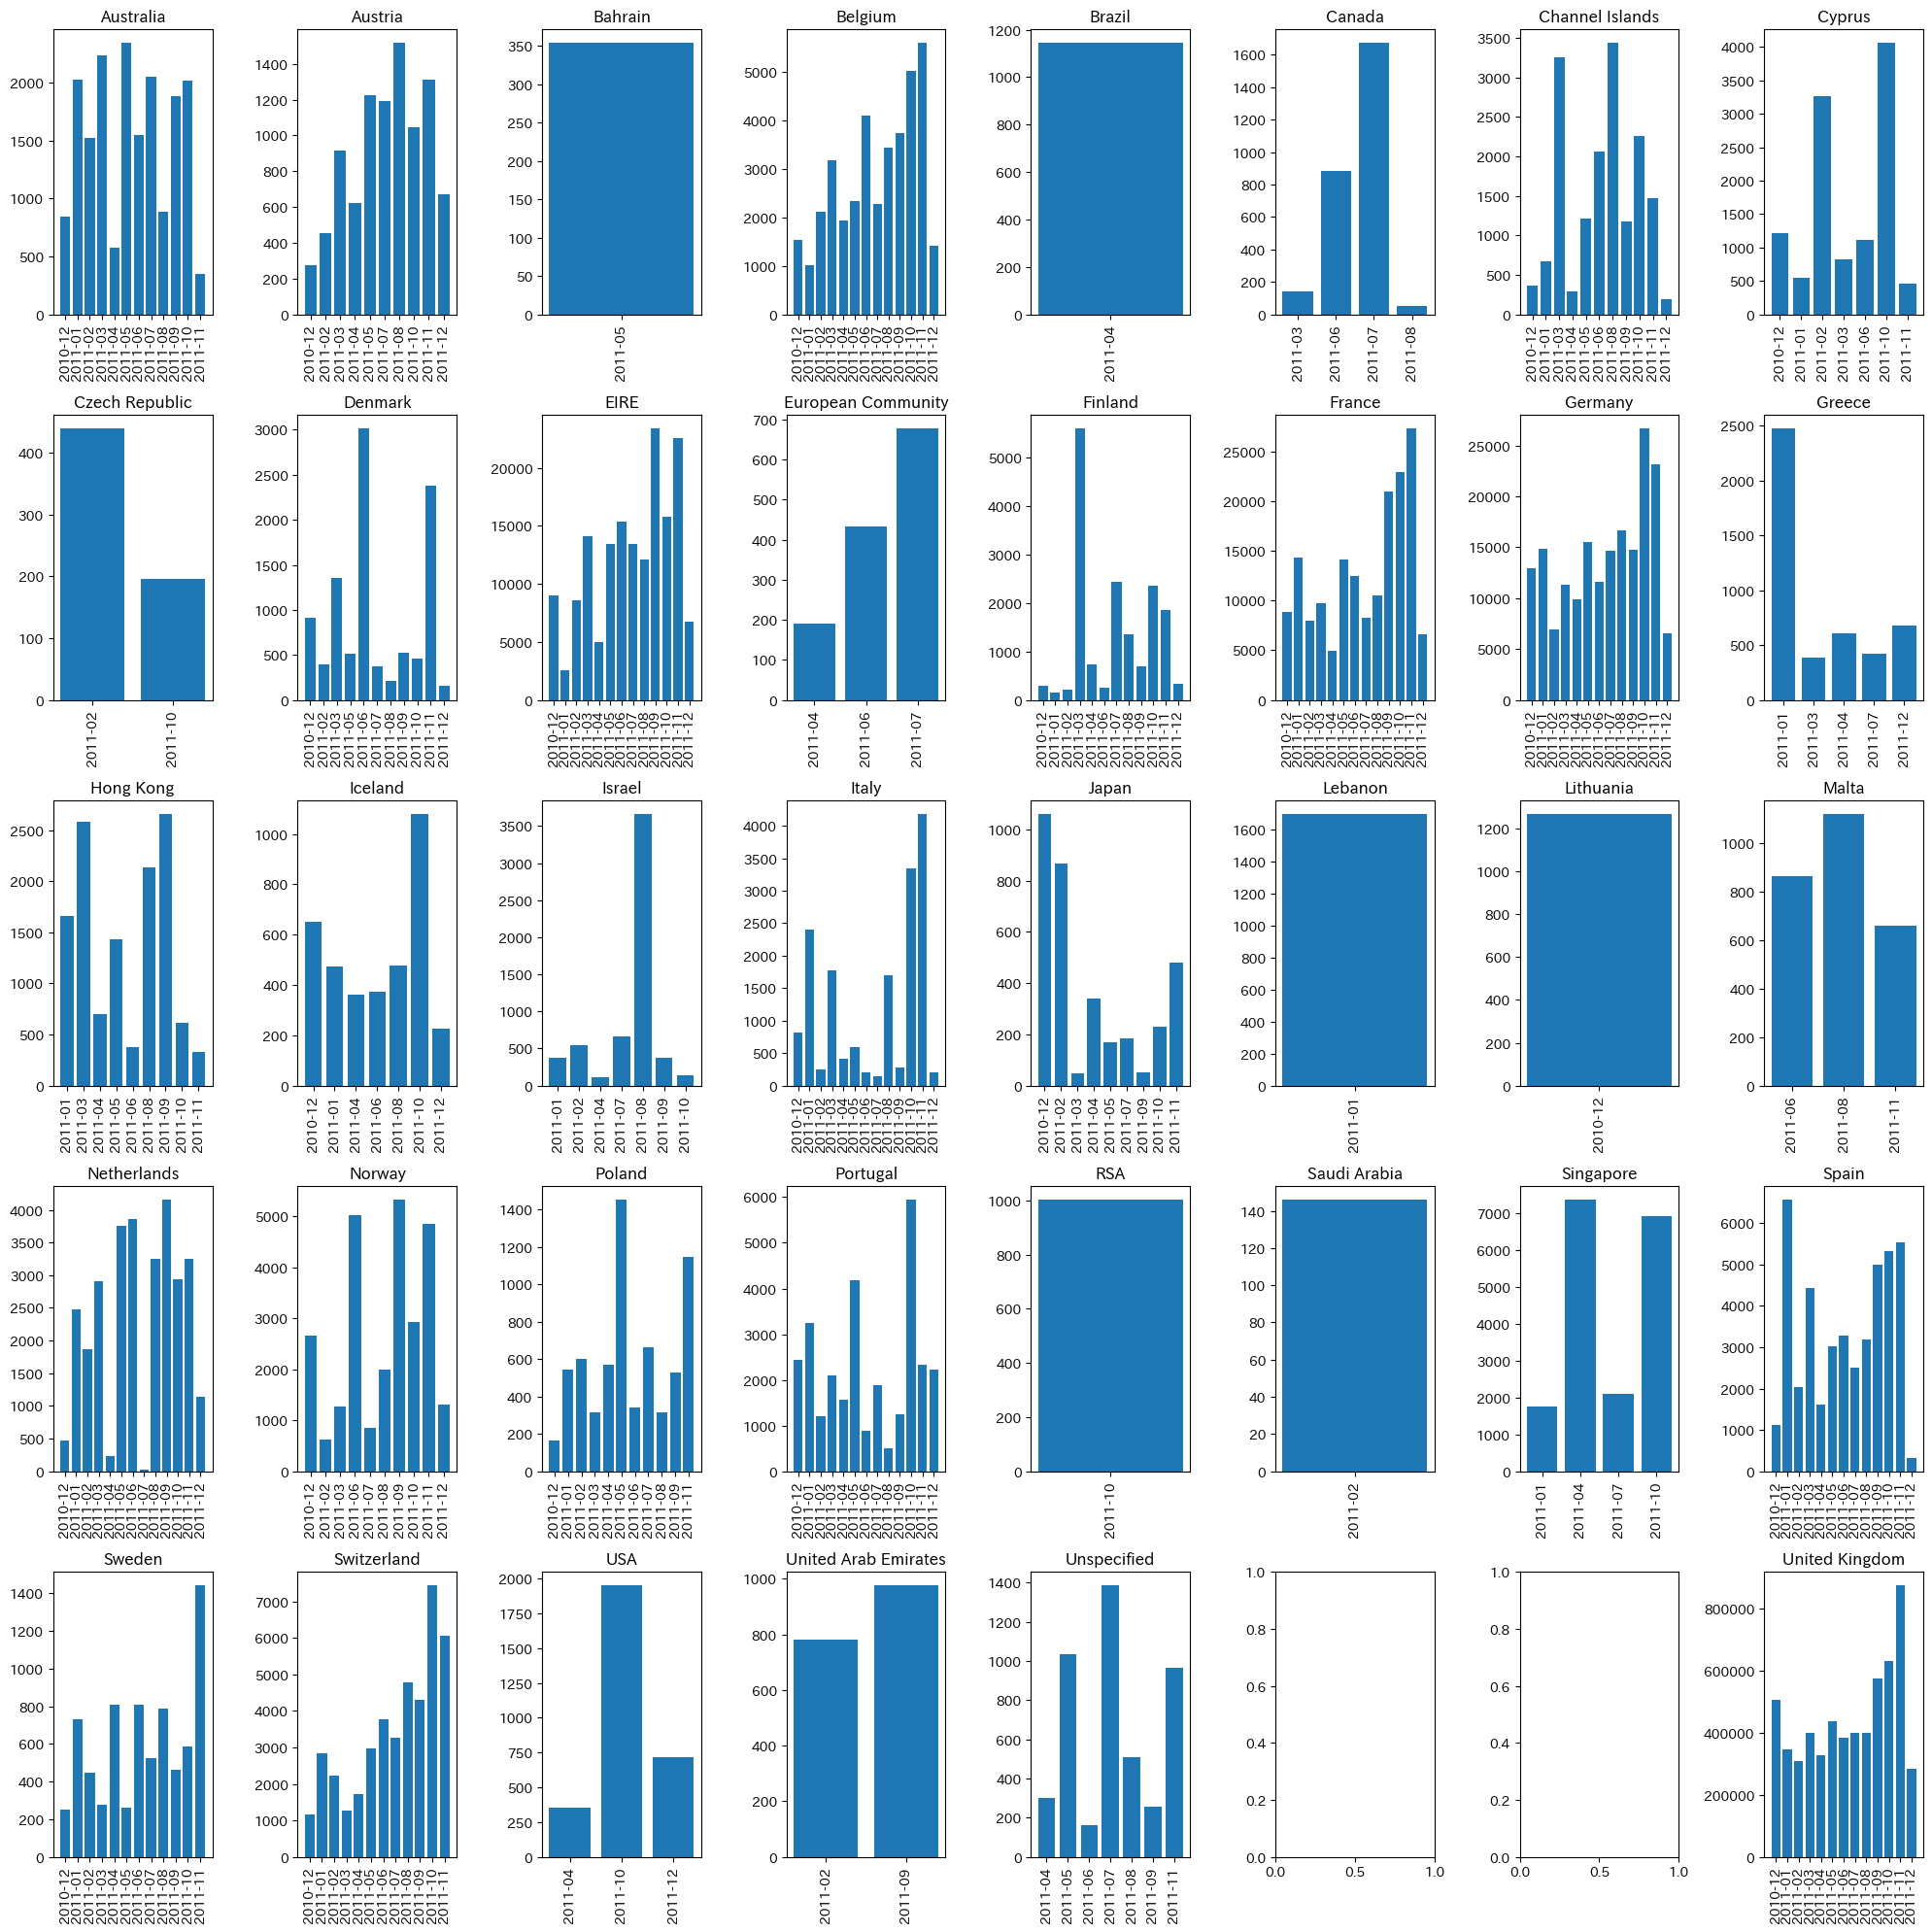

In [ ]:
def uriage_country(country_name):
    df_uriage_country = df[df['Country'] == country_name].copy()
    df_uriage_country['Date'] = df_uriage_country['InvoiceDate'].dt.to_period('M')
    df_uriage_country = df_uriage_country.groupby(['Date', 'Country'])['TotalValue'].sum().reset_index()

    x = df_uriage_country['Date'].astype(str)
    y = df_uriage_country['TotalValue']
    plt.title(f'{country_name}')
    plt.bar(x, y)
    plt.xticks(rotation=90)

# 5行8列のサブプロットを作成
fig, axes = plt.subplots(5, 8, figsize=(20, 20), tight_layout=True)

# 各国のグラフを配置
for i, country_name in enumerate(countries):
    ax = axes[i // 8, i % 8]
    uriage_country(country_name)  # グラフを描画
    plt.sca(ax)  # 描画する軸を設定する

In [ ]:
# 指定された期間のデータを抽出
df_period = df[(df['InvoiceDate'].dt.year >= 2010) & (df['InvoiceDate'].dt.year <= 2011)]

# 月ごとに売上データを集計
monthly_sales_data = []
for year in range(2010, 2012):
    for month in range(1, 13):
        monthly_sales = df_period[(df_period['InvoiceDate'].dt.year == year) & (df_period['InvoiceDate'].dt.month == month)].groupby('Country')['TotalValue'].sum().reset_index()
        monthly_sales['Year'] = year
        monthly_sales['Month'] = month
        monthly_sales_data.append(monthly_sales)

# 月次売上データを結合
df_combined = pd.concat(monthly_sales_data, ignore_index=True)
df_combined

,Country,TotalValue,Year,Month
0,Australia,842.15,2010,12
1,Austria,277.20,2010,12
2,Belgium,1529.71,2010,12
3,Channel Islands,363.53,2010,12
4,Cyprus,1214.62,2010,12
...,...,...,...,...
291,Norway,1309.32,2011,12
292,Portugal,2221.57,2011,12
293,Spain,316.21,2011,12
294,USA,716.76,2011,12


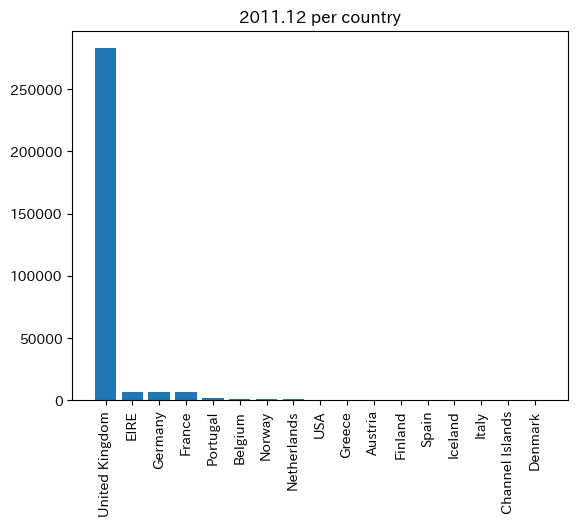

In [ ]:
def uriage_monthly(year, month):
  df_uriage_country = df[(df['InvoiceDate'].dt.year == year) & (df['InvoiceDate'].dt.month == month)].groupby('Country')['TotalValue'].sum().reset_index()
  df_uriage_country = df_uriage_country.sort_values(by='TotalValue', ascending=False)
  x = df_uriage_country['Country']
  y = df_uriage_country['TotalValue']
  plt.title(f'{year}.{month} per country')
  plt.bar(x, y)
  plt.xticks(rotation=90)

  return plt.show()

uriage_monthly(2011, 12)


-------------------------------------------------------

In [ ]:
# 6. 2011年1～6月の期間における、購入者が500人以上の商品のうち、最もファンが多い順に並べてください
# ヒント：リピート率（https://www.tsuhan-marketing.com/blog/basic/regarding_repeatrate）

2011年1～6月のデータに絞る。

総顧客数をカウント

商品をグループ化して、顧客数（同じ人を数えない）をカウント＝購入人数

購入人数５００人以上に絞る。

リピート率（購入人数/総顧客数×１００）列を作り降順に並べる。

In [ ]:
#2011年１～６月のデータに絞る。
_df_2011_zenki = df[(df['InvoiceDate'].dt.year == 2011) & (df['InvoiceDate'].dt.month <= 6)]
_df_2011_zenki.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalValue,最終購入日
42481,539993,22386,JUMBO BAG PINK POLKADOT,10,2011-01-04 10:00:00,1.95,13313.0,United Kingdom,19.5,2011-01-04 10:00:00
42482,539993,21499,BLUE POLKADOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.5,2011-01-04 10:00:00
42483,539993,21498,RED RETROSPOT WRAP,25,2011-01-04 10:00:00,0.42,13313.0,United Kingdom,10.5,2011-01-04 10:00:00
42484,539993,22379,RECYCLING BAG RETROSPOT,5,2011-01-04 10:00:00,2.10,13313.0,United Kingdom,10.5,2011-01-04 10:00:00
42485,539993,20718,RED RETROSPOT SHOPPER BAG,10,2011-01-04 10:00:00,1.25,13313.0,United Kingdom,12.5,2011-01-04 10:00:00


CustomerIDは欠損値が多い（たぶんカード会員かなにか） InvoiceNoがレシートらしいのでそれで数えてみる。

In [ ]:
#総顧客数をカウント nunique()で重複を許さずユニークな要素をカウントできる。
unique_customers = df['InvoiceNo'].nunique()
unique_customers

18734

In [ ]:
#商品をグループ化して、顧客数（同じ人を数えない）をカウント＝購入人数
_df_syohin_repeat = _df_2011_zenki.groupby('Description')['InvoiceNo'].nunique().reset_index()
_df_syohin_repeat = _df_syohin_repeat.rename(columns={'InvoiceNo': '購入人数'})
_df_syohin_repeat['リピート率'] = ((_df_syohin_repeat['購入人数'] / unique_customers) * 100).round(1)
df_syohin_repeat = _df_syohin_repeat.sort_values(by='購入人数', ascending=False)
df_syohin_repeat

,Description,購入人数,リピート率
2454,REGENCY CAKESTAND 3 TIER,917,4.9
3214,WHITE HANGING HEART T-LIGHT HOLDER,888,4.7
2064,PARTY BUNTING,840,4.5
1557,JUMBO BAG RED RETROSPOT,764,4.1
1710,LUNCH BAG RED RETROSPOT,650,3.5
...,...,...,...
345,BLING KEY RING STAND,1,0.0
1422,HAYNES CAMPER SHOULDER BAG,1,0.0
2708,SET OF 6 T-LIGHTS SANTA,1,0.0
1451,HEN HOUSE W CHICK IN NEST,1,0.0


In [ ]:
#購入人数５００人以上に絞る。
df_syohin_repeat = _df_syohin_repeat.query('購入人数 >= 500')
df_syohin_repeat.sort_values(by='購入人数', ascending=False)

,Description,購入人数,リピート率
2454,REGENCY CAKESTAND 3 TIER,917,4.9
3214,WHITE HANGING HEART T-LIGHT HOLDER,888,4.7
2064,PARTY BUNTING,840,4.5
1557,JUMBO BAG RED RETROSPOT,764,4.1
1710,LUNCH BAG RED RETROSPOT,650,3.5
2644,SET OF 3 CAKE TINS PANTRY DESIGN,609,3.3
2003,PACK OF 72 RETROSPOT CAKE CASES,578,3.1
1883,NATURAL SLATE HEART CHALKBOARD,568,3.0
1526,JAM MAKING SET WITH JARS,533,2.8
1555,JUMBO BAG PINK POLKADOT,527,2.8


-------------------------------------------------------

In [ ]:
# 7. 2011年における、購買の売上分解ツリー（売上のロジックツリー）を作成してください
# ツリーの描写は不要です。必要な項目を出力してください

-------------------------------------------------------

In [ ]:
# 8. 2011年1～6月の期間において、バスケット分析を行ってください

https://toukei-lab.com/association-analysis#1

https://qiita.com/makaishi2/items/c5f06f844cdb8454b6c3

バスケット分析

ある事象と同時に発生する事象が何かを分析する手法。

ex）ある商品を購入した際によく一緒に買われている商品は何か？

confidence(信頼度)：商品Aを買った人のうち、どれくらいの人が商品Ｂも買ったかという指標

Support(支持度)：そもそも商品Aと商品Bを一緒に買ったひとがどれくらいいるのかという指標

Lift(リフト)：そもそも商品A自体がどれだけうれているのかという指標

Aprioriアルゴリズム：多対多の関係性を計算で行うアルゴリズム

In [ ]:
df.head()

In [ ]:
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [ ]:
df_basket = df.copy()

# 購入した商品のフラグを立てる
df_basket['Bought'] = True

# InvoiceNoとDescriptionの組み合わせでグループ化し、購入したかどうかを示すフラグを設定する
df_basket = df_basket.pivot_table(index='InvoiceNo', columns='Description', values='Bought', fill_value=False)

df_basket = df_basket.astype(bool)

# データフレームを表示
df_basket

Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,wrongly coded 20713,wrongly coded 23343,wrongly coded-23343,wrongly marked,wrongly marked 23343,wrongly marked carton 22804,wrongly marked. 23343 in box,wrongly sold (22719) barcode,wrongly sold as sets,wrongly sold sets
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536366,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536368,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536369,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C581484,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C581490,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
C581499,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
df_basket.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24446 entries, 536365 to C581569
Columns: 4223 entries,  4 PURPLE FLOCK DINNER CANDLES to wrongly sold sets
dtypes: bool(4223)
memory usage: 98.6+ MB


In [ ]:
from mlxtend.frequent_patterns import apriori

# 支持度の算出
freq_items = apriori(df_basket,  # データフレーム
min_support  = 0.01,    # 支持度(support)の最小値
use_colnames = True,    # 出力値のカラムに購入商品名を表示
max_len      = None,    # 生成されるitemsetsの個数
#verbose = 0,            # low_memory=Trueの場合のイテレーション数
#low_memory = False,    # メモリ制限あり＆大規模なデータセット利用時に有効
)

# 結果出力
freq_items = freq_items.sort_values("support", ascending = False).reset_index(drop=True)
freq_items.head()

,support,itemsets
0,0.094167,(WHITE HANGING HEART T-LIGHT HOLDER)
1,0.088726,(REGENCY CAKESTAND 3 TIER)
2,0.087335,(JUMBO BAG RED RETROSPOT)
3,0.069786,(PARTY BUNTING)
4,0.065737,(LUNCH BAG RED RETROSPOT)


In [ ]:
# アソシエーション・ルール抽出のための評価指標の算出
df_rules = association_rules(
freq_items,             # supportとitemsetsを持つデータフレーム
metric = "confidence",  # アソシエーション・ルールの評価指標
min_threshold = 0.0,    # metricsの閾値
)
df_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.050356,0.087335,0.034075,0.676686,7.748130,0.029677,2.822840,0.917119
1,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.087335,0.050356,0.034075,0.390164,7.748130,0.029677,1.557212,0.954279
2,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.043238,0.045815,0.032071,0.741722,16.189404,0.030090,3.694408,0.980632
3,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.045815,0.043238,0.032071,0.700000,16.189404,0.030090,3.189206,0.983280
4,(JUMBO BAG RED RETROSPOT),(JUMBO STORAGE BAG SUKI),0.087335,0.049129,0.029984,0.343326,6.988290,0.025694,1.448010,0.938903


In [ ]:
#結果を絞る
df_rules2 = df_rules[(df_rules["support"]>=0.03)&(df_rules["confidence"]>=0.5)&(df_rules["lift"]>3.0)]
df_rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.050356,0.087335,0.034075,0.676686,7.748130,0.029677,2.822840,0.917119
2,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER ),0.043238,0.045815,0.032071,0.741722,16.189404,0.030090,3.694408,0.980632
3,(ROSES REGENCY TEACUP AND SAUCER ),(GREEN REGENCY TEACUP AND SAUCER),0.045815,0.043238,0.032071,0.700000,16.189404,0.030090,3.189206,0.983280


-------------------------------------------------------

In [ ]:
# 9. 2011年1～6月を前期間、7～12月を後期間にして、「84406B」（CREAM CUPID HEARTS COAT HANGER）の商品を前期間に購入した人が、後期間に購入した商品を分析してください

-------------------------------------------------------

In [ ]:
# 下記は難易度高なので、できればでOKです。

# 10. 購買の傾向をもとに、商品同士のネットワーク図を作成してください
# ネットワーク図：https://www.sejuku.net/blog/91371
#
# ※この分析は、SQLとPythonそれぞれではなく、組み合わせて分析してください